# Homework 1, DS-GA 1012, Spring 2019

## Grace Han (jh5990@nyu.edu)

## Due Feburary 13, 2019 at 2pm (ET)

Download the data zip `DS-GA1012-hw1-data.zip`. Complete the following questions in the notebook and submit your completed notebook on NYU Classes.

## 1. Exploring effect of context size [30 pts]

We face many implicit and explicit design decisions in creating distributional word representations. For example, in lecture and in lab, we created word vectors using a co-occurence matrix built on neighboring pairs of words. We might suspect, however, that we can get more signal of word similarity by considering larger contexts than pairs of words.

__a__. Write `build_cooccurrence_matrix`, which generates the co-occurence matrix for a window of arbitrary size and for the vocabulary of `max_vocab_size` most frequent words. Feel free to modify the code used in lab [10 pts]

__Answer__

In [5]:
from collections import defaultdict
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
import time

def load_sst(data_file):
    with open(data_file, 'r') as data_fh:
        data_fh.readline() # skip the header
        data = [r.split('\t')[1] for r in data_fh.readlines()]
    return data # a list of sentences

def build_cooccurrence_matrix(data, max_vocab_size=20000, context_size=1):
    """ Build a co-occurrence matrix
    
    args:
        - data: iterable where each item is a list of tokens (string) 
        - max_vocab_size: maximum vocabulary size
        - context_size: window around a word that is considered context
            context_size=1 should consider pairs of adjacent words
            
    returns:
        - co-occurrence matrix: numpy array where row i corresponds to the co-occurrence counts for word i"""
    def get_token_frequencies():
        tok2freq = defaultdict(int) # frequency of each token in the entire data
        coocur_counts = defaultdict(lambda: defaultdict(int))
        
        for datum in data:
            tokens = datum.strip().split()
            for i, tok in enumerate(tokens):
                tok2freq[tok] += 1
                coocur_counts[tok][tok] += 1
                if i < len(tokens) - context_size:
                    for j in range(1, context_size+1):
                        coocur_counts[tok][tokens[i + j]] += 1
                        coocur_counts[tokens[i + j]][tok] += 1
                elif i < len(tokens) - 1: # compute co-occurence for last context_size tokens
                    for j in range(1, len(tokens)-i):
                        coocur_counts[tok][tokens[i + j]] += 1
                        coocur_counts[tokens[i + j]][tok] += 1
                            
        return tok2freq, coocur_counts
    
    def prune_vocabulary(tok2freq, max_vocab_size):
        """ Prune vocab by taking max_vocab_size most frequent words """
        tok_and_freqs = [(k, v) for k, v in tok2freq.items()]
        tok_and_freqs.sort(key = lambda x: x[1], reverse=True) # sorts in-place
        tok2idx = {tok: idx for idx, (tok, _) in enumerate(tok_and_freqs[:max_vocab_size])}
        idx2tok = {idx: tok for tok, idx in tok2idx.items()}
        return tok2idx, idx2tok
    
    def _build_coocurrence_mat(idx2tok, coocur_counts):
        vocab_size = len(idx2tok)
        mat = [[0 for _ in range(vocab_size)] for _ in range(vocab_size)]
        for i in range(vocab_size - 1):
            for j in range(i, vocab_size):    # start from i instead of i+1 to fill in the diagonal matrix
                if coocur_counts[idx2tok[i]][idx2tok[j]]:
                    mat[i][j] = coocur_counts[idx2tok[i]][idx2tok[j]]
                    mat[j][i] = coocur_counts[idx2tok[i]][idx2tok[j]]
        return np.array(mat)        

    
    print("Counting words...")
    start_time = time.time()
    tok2freq, coocur_counts = get_token_frequencies()
    print("\tFinished counting words in %.5f" % (time.time() - start_time))

    print("Pruning vocabulary...")
    tok2idx, idx2tok = prune_vocabulary(tok2freq, max_vocab_size)
    start_time = time.time()
    print("\tFinished pruning vocabulary in %.5f" % (time.time() - start_time))
    
    print("Building co-occurrence matrix...")
    start_time = time.time()
    coocur_mat = _build_coocurrence_mat(idx2tok, coocur_counts)
    print("\tFinished building co-occurrence matrix in %.5f" % (time.time() - start_time))
    return coocur_mat, tok2idx, idx2tok

Use your implementation of `build_cooccurrence_matrix` to generate the co-occurence matrix from the sentences of [SST](http://nlp.stanford.edu/~socherr/stanfordSentimentTreebank.zip) (file `datasetSentences.txt`) with `context_size=2` and `max_vocab_size=10000`. What is the co-occurrence count of the words "the" and "end"? 

__Answer__

In [6]:
data_file = 'HW1/datasetSentences.txt'

data = load_sst(data_file)
mat, tok2idx, idx2tok = build_cooccurrence_matrix(data, max_vocab_size=10000, context_size=2)

Counting words...
	Finished counting words in 0.69655
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 26.71117


In [7]:
# Check the diagonal elements in the matrix
mat

array([[11164,    95,   636, ...,     0,     0,     1],
       [   95, 11179,  1383, ...,     0,     1,     0],
       [  636,  1383,  8435, ...,     0,     0,     0],
       ..., 
       [    0,     0,     0, ...,     2,     0,     0],
       [    0,     1,     0, ...,     0,     2,     0],
       [    1,     0,     0, ...,     0,     0,     0]])

In [8]:
print("Co-occurrence count of \"the\" and \"end\" : %d" % mat[tok2idx['the']][tok2idx['end']])

Co-occurrence count of "the" and "end" : 98


__b__. Plot the effect of varying context size in $\{1, 2, 3, 4\}$ (leaving all the other settings the same) on the quality of the learned word embeddings, as measured by performance (Spearman correlation) on the word similarity dataset [MTurk-771](http://www2.mta.ac.il/~gideon/mturk771.html) between human judgments and cosine similarity of the learned word vectors (see lab). [12 pts]

__Answer__

In [9]:
def vector_length(u):
    return np.sqrt(np.dot(u, u))

def cosine(u, v):        
    return 1.0 - (np.dot(u, v) / (vector_length(u) * vector_length(v)))

def prob_norm(u):
    return u / np.sum(u)

def rowwise_norm_mat(mat):
    return np.array([prob_norm(u) for u in mat])

In [10]:
from scipy.stats import spearmanr

def load_word_similarity_dataset(data_file):
    with open(data_file, 'r') as data_fh:
        raw_data = data_fh.readlines()
    data = []
    trgs = []
    for datum in raw_data:
        datum = datum.strip().split(',')
        data.append((datum[0], datum[1]))
        trgs.append(float(datum[2]))
    return data, trgs

def evaluate_word_similarity(word_pairs, targets, mat, tok2idx):
    preds = []
    trgs = []
    n_exs = 0
    for (word1, word2), trg in zip(word_pairs, targets):
        if word1 in tok2idx and word2 in tok2idx:
            pred_sim = 1 - cosine(mat[tok2idx[word1]], mat[tok2idx[word2]])
            preds.append(pred_sim)
            trgs.append(trg)
            n_exs += 1
    
    rho, pvalue = spearmanr(trgs, preds)
    print("Evaluated on %d of %d examples" % (n_exs, len(word_pairs)))
    return rho

In [11]:
test_file = 'HW1/MTURK-771.csv'
test_data, test_trgs = load_word_similarity_dataset(test_file)

In [12]:
print("* Context size: 1")
mat1, tok2idx1, idx2tok1 = build_cooccurrence_matrix(data, max_vocab_size=10000, context_size=1)
print("* Context size: 2")
mat2, tok2idx2, idx2tok2 = build_cooccurrence_matrix(data, max_vocab_size=10000, context_size=2)
print("* Context size: 3")
mat3, tok2idx3, idx2tok3 = build_cooccurrence_matrix(data, max_vocab_size=10000, context_size=3)
print("* Context size: 4")
mat4, tok2idx4, idx2tok4 = build_cooccurrence_matrix(data, max_vocab_size=10000, context_size=4)

norm_mat1 = rowwise_norm_mat(mat1)
norm_mat2 = rowwise_norm_mat(mat2)
norm_mat3 = rowwise_norm_mat(mat3)
norm_mat4 = rowwise_norm_mat(mat4)

* Context size: 1
Counting words...
	Finished counting words in 0.41459
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 52.23208
* Context size: 2
Counting words...
	Finished counting words in 1.59681
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 29.70679
* Context size: 3
Counting words...
	Finished counting words in 0.99853
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 30.64419
* Context size: 4
Counting words...
	Finished counting words in 2.65033
Pruning vocabulary...
	Finished pruning vocabulary in 0.00000
Building co-occurrence matrix...
	Finished building co-occurrence matrix in 35.12511


In [13]:
rho1 = evaluate_word_similarity(test_data, test_trgs, norm_mat1, tok2idx)
rho2 = evaluate_word_similarity(test_data, test_trgs, norm_mat2, tok2idx)
rho3 = evaluate_word_similarity(test_data, test_trgs, norm_mat3, tok2idx)
rho4 = evaluate_word_similarity(test_data, test_trgs, norm_mat4, tok2idx)

Evaluated on 248 of 771 examples
Evaluated on 248 of 771 examples
Evaluated on 248 of 771 examples
Evaluated on 248 of 771 examples


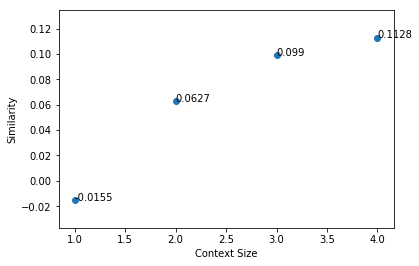

In [14]:
context_sizes = [1,2,3,4]
similarities = [rho1, rho2, rho3, rho4]

plt.scatter(context_sizes, similarities)
plt.xlabel('Context Size')
plt.ylabel('Similarity')
for x, y in zip(context_sizes, similarities):
    plt.text(x, y, str(round(y, 4)))
plt.show()

__c__. Briefly discuss the pros and cons of varying (i) the context size (ii) the vocabulary size (iii) using bigrams instead of unigrams (iv) using subword tokens instead of words. [8 pts]

__Answer__

(i) Varying the context size: A small context size lets you discover the syntactic characteristic of the target word. For example which words often appear side by side with a certain word. But this may not capture the semantic characteristic of the word. For example, in what type of sentences the word frequently appears in. For big context size the pros and cons will be the opposite.

(ii) Varying the vocabulary size: A small vocaublary size will let you focus on the high frequency words in smaller dimension. It will be good if you are only looking into those words. However, if you want to consider a bigger range of words you should consider a bigger vocabulary but you will have to work with a high dimensional and sparse matrix.

(iii) Using bigrams instead of unigrams: By using bigrams ordering of words will be taken into account. However, the maximum vocabulary size becomes $V^2$ where $V$ is the unigram vocabulary size. You will have to work with a high dimensional and sparse matrix.

(iv) Using subword tokens instead of words: You will be able to capture the syntactic patterns of how words are combined or transformed. However this is not effective for the case where you want to capture the semantic characteristic of the tokens since creating subwords out of words produces bigger number of tokens. This means the dimesionality of the token matrix will be increased and be sparse.

## 2. Pointwise Mutual Information [20 pts]

In lecture, we introduced __pointwise mutual information__ (PMI), which addresses the issue of normalization removing information about absolute magnitudes of counts. The PMI for word $\times$ context pair $(w,c)$ is 

$$\log\left(\frac{P(w,c)}{P(w) \cdot P(c)}\right)$$

with $\log(0) = 0$. This is a measure of how far that cell's value deviates from what we would expect given the row and column sums for that cell.

__a__. Implement `pmi`, a function which takes in a co-occurence matrix and returns the matrix with PMI normalization applied. [15 pts]

__Answer__

In [15]:
def pmi(mat, positive=False):
    """Pointwise mutual information
    
    args:
        - mat: 2d np.array to apply PMI
        - positive: set to True for PPMI
        
    returns:
        - pmi_mat: matrix of same shape with PMI applied
    """
    def custom_log(num):
        if not num:
            return 0
        else:
            return np.log(num)
        
    pmi_mat = [[0 for _ in range(len(mat[0]))] for _ in range(len(mat))]
    sum_w = np.reshape(np.sum(mat,axis=1), (mat.shape[0], 1))
    sum_c = np.reshape(np.sum(mat,axis=0), (1, mat.shape[1]))
    total_words = np.sum(sum_w)
    for i in range(len(mat)):
        for j in range(i, len(mat[0])):
            numerator = mat[i][j] / total_words
            denominator = (sum_w[i][0] / total_words) * (sum_c[0][j] / total_words)
            val = custom_log(numerator / denominator)
            if positive==True:
                val = max(val, 0)
            pmi_mat[i][j] = val
            pmi_mat[j][i] = val
    return pmi_mat

Apply PMI to the co-occurence matrix computed above with `context_size=1`. What is the PMI between the words "the" and "end"?

__Answer__

In [16]:
pmi_mat1 = pmi(mat1)

print(" PMI between the words \"the\" and \"end\": %.5f" % pmi_mat1[tok2idx['the']][tok2idx['end']])

 PMI between the words "the" and "end": 1.72683


__b__. We also consider an extension of PMI, positive PMI (PPMI), that maps all negative PMI values to 0.0 ([Levy and Goldberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization)). 
Write `ppmi`, which is the same as `pmi` except it applies PPMI instead of PMI (feel free to implement it as an option of `pmi`). What is the PMI of the words "the" and "start"? The PPMI? [5 pts]

__Answer__

In [19]:
def pmi(mat, positive=False):
    """Pointwise mutual information
    
    args:
        - mat: 2d np.array to apply PMI
        - positive: set to True for PPMI
        
    returns:
        - pmi_mat: matrix of same shape with PMI applied
    """
    def custom_log(num):
        if not num:
            return 0
        else:
            return np.log(num)
        
    pmi_mat = [[0 for _ in range(len(mat[0]))] for _ in range(len(mat))]
    sum_w = np.reshape(np.sum(mat,axis=1), (mat.shape[0], 1))
    sum_c = np.reshape(np.sum(mat,axis=0), (1, mat.shape[1]))
    total_words = np.sum(sum_w)
    for i in range(len(mat)):
        for j in range(i, len(mat[0])):
            numerator = mat[i][j] / total_words
            denominator = (sum_w[i][0] / total_words) * (sum_c[0][j] / total_words)
            val = custom_log(numerator / denominator)
            if positive==True:
                val = max(val, 0)
            pmi_mat[i][j] = val
            pmi_mat[j][i] = val
    return pmi_mat

In [20]:
pmi_mat1 = pmi(mat1, False)
ppmi_mat1 = pmi(mat1, True)

In [21]:
print("PMI between the words \"the\" and \"start\": %.9f" % pmi_mat1[tok2idx['the']][tok2idx['start']])
print("PPMI between the words \"the\" and \"start\": %.9f" % ppmi_mat1[tok2idx['the']][tok2idx['start']])

PMI between the words "the" and "start": 0.292151278
PPMI between the words "the" and "start": 0.292151278


## 3. Analyzing PMI [25 pts]

__a__. Consider the matrix `np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]])`. Reweight this matrix using `ppmi`. (i) What is the value obtained for cell `[0,0]`, and (ii) give a brief description for what is likely problematic about this value. [10 pts]

__Answer__

In [22]:
pmi(np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]]), True)

[[1.6089380373924496, 0, 0],
 [0, 0, 0.28788209245444807],
 [0, 0.28788209245444807, 0]]

(i) The value for cell [0,0] is 1.6089380373924496.

(ii) The value of cell [0,0] is shown as a much higher value compared to any other values in the cell even though the the value of [0,0] in the original matrix is significantly lower than other values. Low frequency values should be considered with less weight when computing the PMI.

__b__. Give a suggestion for dealing with the problematic value and explain why it deals with this. Demonstrate your suggestion empirically [10 pts]

__Answer__

We can use the Normalized PMI.

The Normalized PMI(NPMI)  for word $\times$ context pair $(w,c)$ is 

$$\log\left(\frac{P(w,c)}{P(w) \cdot P(c)}\right)\bigg/{-\log{P(w,c)}}$$

This takes into account the co-occurence frequency of the word pairs. Word pairs $w, c$ that have low co-occurence frequency has small $P(w,c)$ $\Rightarrow$ small  $\log{P(w,c)}$ $\Rightarrow$ big  $-\log{P(w,c)}$ $\Rightarrow$ small  $-1 / \log{P(w,c)}$

Therefore multiplying PMI by $-1 / \log{P(w,c)}$ adds co-occurence frequency factor to the PMI and deals the problem we faced above.

The value of NPMI can be viewed as follows.

1) $w$ and $c$ never co-occur 

$$P(w,c) = 0 \Rightarrow \log{P(w,c)} \rightarrow -\infty \Rightarrow NPMI = -1$$

2) $w$ and $c$ are independent

$$P(w,c) = P(w)P(c) \Rightarrow PMI = 0 \rightarrow NPMI = 0$$

3) $w$ and $c$ always co-occurs

$$P(w,c) = P(w) = P(c) \Rightarrow NPMI = 1$$

In [ ]:
# Define a normalized PMI

def npmi(mat, positive=False):
    """Nomralized Pointwise mutual information
    
    args:
        - mat: 2d np.array to apply NPMI
        - positive: set to True for PPMI
        
    returns:
        - npmi_mat: matrix of same shape with PMI applied
    """
    def custom_log(num):
        if not num:
            return 0
        else:
            return np.log(num)
        
    npmi_mat = [[0 for _ in range(len(mat[0]))] for _ in range(len(mat))]
    sum_w = np.reshape(np.sum(mat,axis=1), (mat.shape[0], 1))
    sum_c = np.reshape(np.sum(mat,axis=0), (1, mat.shape[1]))
    total_words = np.sum(sum_w)

    for i in range(len(mat)):
        for j in range(i, len(mat[0])):
            numerator = mat[i][j] / total_words
            denominator = (sum_w[i][0] / total_words) * (sum_c[0][j] / total_words)
            _pmi = custom_log(numerator / denominator)
            normalizer = (-1) * np.log(numerator)
            val = _pmi / normalizer
            if positive==True:
                val = max(val, 0)
            npmi_mat[i][j] = val
            npmi_mat[j][i] = val
    return npmi_mat

In [ ]:
# NPMI
npmi(np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]]), False)

In [ ]:
# Positive NPMI
npmi(np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]]), True)

__c__. Consider starting with a word-word co-occurence matrix and applied PMI to this matrix. (i) Which of the following describe the resulting vectors: sparse, dense, high-dimensional, low-dimensional (ii) If you wanted the opposite style of representation, what could you do? [5 pts]


__Answer__

(i) Sparse and high-dimensional.

(ii) Use Latent Semantic Analysis to perform dimensionality reduction on the matrix.

## 4. Word Analogy Evaluation [25 pts]

Word analogies provide another kind of evaluation for distributed representations. Here, we are given three vectors A, B, and C, in the relationship

_A is to B as C is to __ _

and asked to identify the fourth that completes the analogy. These analogies are by and large substantially easier than the classic brain-teaser analogies that used to appear on tests like the SAT, but it's still an interesting, demanding
task. 

The core idea is that we make predictions by creating the vector

$$(A - B) + C$$ 

and then ranking all vectors based on their distance from this new vector, choosing the closest as our prediction.

__a__. Implement the function `analogy_completion`. [9 pts]

__Answer__

In [ ]:
from operator import itemgetter

def analogy_completion(a, b, c, mat):
    """Compute ? in 
    a is to b as c is to ? 
    as the closest to (b-a) + c
    
    mat:
        - a dictionary of words and their vector representations
        - key: word
        - value: vector representation of each word as an array
    """
    for x in (a, b, c):
        if x not in mat.keys():
            raise ValueError('%s is not in this dataset' % x)
    new_vec = mat[b] - mat[a] + mat[c]
    # compute the cosine distance
    distances = [(word, cosine(new_vec, mat[word])) for word in mat.keys() if word not in (a, b, c)]
    return sorted(distances, key=itemgetter(1), reverse=False)

__b__. Our simple word embeddings likely won't perform well on this task. Let's instead look at some high quality pretrained word embeddings. Write code to load 300-dimensional [GloVe word embeddings](http://nlp.stanford.edu/data/glove.840B.300d.zip) trained on 840B tokens. Each line of the file is formatted as a word followed by 300 floats that make up its corresponding word embedding (all space delimited). The entries of GloVe word embeddings are not counts, but instead are learned via machine learning. Use your `analogy_completion` code to complete the following analogies using the GloVe word embeddings. [6 pts]

__Answer__

In [ ]:
def load_glove(glove_file, n_vecs=20000):
    """ """
    tok2vec = {}
    with open(glove_file, 'r') as glove_fh:
        for i, row in enumerate(glove_fh):
            word, vec = row.split(' ', 1)
            tok2vec[word] = np.array([float(n) for n in vec.split(' ')])
            if i >= n_vecs:
                break
    return tok2vec

In [ ]:
glove_file = "HW1/glove.840B.300d.txt"
glove_vecs = load_glove(glove_file, n_vecs=50000)

In [ ]:
glove_vecs[:3]

In [ ]:
# "Beijing" is to "China" as "Paris" is to ?
analogy_completion("Beijing", "China", "Paris", glove_vecs)[:5]

In [ ]:
# "gold" is to "first" as "silver" is to ?
analogy_completion("gold", "first", "silver", glove_vecs)[:5]

In [ ]:
# "Italian" is to "mozzarella" as "American" is to ?
analogy_completion("Italian", "mozzarella", "American", glove_vecs)[:5]

In [26]:
# "research" is to "fun" as "engineering" is to ?
analogy_completion("research", "fun", "engineering", glove_vecs)[:5]

[('awesome', 0.50272776147317089),
 ('cool', 0.52646862649484039),
 ('enjoyable', 0.53702365147115905),
 ('cute', 0.54849439029975011),
 ('exciting', 0.55400816850583301)]

c. Let's get a more quantitative, aggregate sense of the quality of GloVe embeddings. Load the analogies from `gram6-nationality-adjective.txt` and evaluate GloVe embeddings. Report the mean reciprocal rank of the correct answer (the last word on each line) for each analogy. [10 pts]

__Answer__

In [27]:
def analogy_evaluation(glove_vecs, test_file, verbose=False):
    # Read the test data file
    test_file = "HW1/" + test_file
    test_data = [line.split() for line in open(test_file).read().splitlines()]
    test_data = [x for x in test_data if set(x) <= set(glove_vecs.keys())]

    result_dic = defaultdict(int)
    ranks = []
    
    # a is to b as c is to d
    for a, b, c, d in test_data:
        predicted_tup = analogy_completion(a, b, c, glove_vecs)
        predicted_words, cos_dis = zip(*predicted_tup)
        result_dic[predicted_words[0]==d] += 1
        ranks.append(1.0 / (predicted_words.index(d)+1))
            
    mrr = np.mean(ranks)
    return (mrr, result_dic)

In [28]:
analogy_evaluation(glove_vecs, "gram6-nationality-adjective.txt")

(0.95335458482388313, defaultdict(int, {True: 219, False: 15}))